# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
#for Windows
# import findspark
# findspark.init()

import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

df = spark.sql('''select 'spark' as hello ''')
df.show()

+-----+
|hello|
+-----+
|spark|
+-----+



In [2]:
# import libraries
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, Window
from pyspark.sql import functions as f
from pyspark.sql.types import IntegerType, StringType
from pyspark.sql.window import Window as w
from pyspark.ml.classification import LogisticRegression, LinearSVC, GBTClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit

import datetime
import sys

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
start = datetime.datetime.now()
def time_elapsed(start=start):
    '''Prints amount of time elapsed since established start time
    start is a pre-established start time'''
    
    now = datetime.datetime.now()
    elapsed = now - start
    return elapsed
    

In [4]:
# create a Spark session
# docs here: https://spark.apache.org/docs/latest/api/python/pyspark.sql.html
# configure = SparkConf().setAppName("Sparkify").setMaster("local")
    #     for SparkSession # .config(conf=configure) \
spark = SparkSession \
    .builder \
    .getOrCreate()
    
    

# Load and Clean Dataset
Clean your dataset, checking for invalid or missing data. For example, records without userids or sessionids. In this workspace, the filename is `mini_sparkify_event_data.json`.

In [5]:
df = spark.read.json('mini_sparkify_event_data.json')
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
df = df.dropna(thresh=15)
df.count()

278154

In [8]:
df.select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [9]:
df.groupBy(df.page).count().show()

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 10082|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   495|
|            Settings|  1514|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Help|  1454|
|             Upgrade|   499|
|               Error|   252|
|      Submit Upgrade|   159|
+--------------------+------+



In [10]:
print(f"Number who confirmed cancellation: {df.where(df.page=='Cancellation Confirmation') \
    .count()}")
df.where(df.page=='Cancellation Confirmation') \
    .groupBy('gender')\
    .count() \
    .show()

Number who confirmed cancellation: 52
+------+-----+
|gender|count|
+------+-----+
|     F|   20|
|     M|   32|
+------+-----+



In [11]:
df.select('userId').distinct().count()

225

In [12]:
df = df.withColumn('datetime',f.from_unixtime(df.ts/1000))

In [13]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', datetime='2018-10-01 00:01:57')

### Defining *Churn*
For now, we'll define *churn* as those who reach the "Cancellation Confirmation" Page.

In [14]:
churns = list(df.where(df.page=='Cancellation Confirmation').select('userId').toPandas()['userId'])

In [15]:
churns = set([int(x) for x in churns])

print(churns)

flag_churn = f.udf(lambda x: 1 if int(x) in churns else 0, IntegerType())

df = df.withColumn('churns', flag_churn(df.userId))

df.head()

{129, 3, 12, 143, 17, 18, 28, 29, 32, 100001, 100003, 100005, 100006, 100007, 100009, 100011, 100012, 100013, 100014, 100015, 100017, 51, 100019, 53, 54, 100023, 100024, 100025, 58, 100022, 100021, 200001, 70, 73, 200011, 200015, 200016, 200017, 200018, 200020, 200021, 87, 200024, 300001, 101, 103, 300007, 105, 106, 121, 122, 125}


Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', datetime='2018-10-01 00:01:57', churns=0)

## Examining page visits between users who 'churn' and users who don't
Particular page view stats might provide insight into users who 'churn'

In [16]:
num_churn = df.where(df.churns==1).select('userId').distinct().count()

num_stay = df.where(df.churns==0).select('userId').distinct().count()

total = df.select('userId').distinct().count()

#amounts in each group
num_churn, num_stay, total

(52, 173, 225)

In [17]:
#raw data for users who churn and don't, toPandas for visualization purposes later
churns_comp_df = df.crosstab('churns','page').toPandas()
churns_comp_df

,churns_page,About,Add Friend,Add to Playlist,Cancel,Cancellation Confirmation,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,1,56,636,1038,52,52,337,32,239,1672,553,36394,967,58,270,9,32,496,1859,112
1,0,439,3641,5488,0,0,1718,220,1215,8410,2673,191714,2966,252,1244,54,127,2050,10692,387


In [18]:
#normalize data to per user numbers
churns_comp_df['churns_page'] = pd.to_numeric(churns_comp_df['churns_page'])

In [19]:
churns_comp_df.values[0] = churns_comp_df.values[0]/num_churn
churns_comp_df.values[1] = churns_comp_df.values[1]/num_stay

In [20]:
#reinsert binary for churning and not (floor division removes the in the churns_page column)
churns_comp_df['churns_page'] = [1,0]

In [21]:
#Average Stats per user
churns_comp_df

,churns_page,About,Add Friend,Add to Playlist,Cancel,Cancellation Confirmation,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,1,1,12,19,1,1,6,0,4,32,10,699,18,1,5,0,0,9,35,2
1,0,2,21,31,0,0,9,1,7,48,15,1108,17,1,7,0,0,11,61,2


In [22]:
#Normalizing Data
# from https://stackoverflow.com/questions/28576540/how-can-i-normalize-the-data-in-a-range-of-columns-in-my-pandas-dataframe
# cols_to_norm = ['Age','Height']
# survey_data[cols_to_norm] = survey_data[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [23]:
#Normalize columns
cols_to_norm = ['About','Add Friend', 'Add to Playlist', 'Downgrade', 'Help', 'Home', 'Logout', 
                'NextSong', 'Roll Advert', 'Save Settings', 'Settings', 'Thumbs Down', 'Thumbs Up', 'Upgrade']
churns_comp_df[cols_to_norm] = churns_comp_df[cols_to_norm].apply(lambda x: x / x.sum())


In [24]:
churns_comp_df

,churns_page,About,Add Friend,Add to Playlist,Cancel,Cancellation Confirmation,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,1,0.333333,0.363636,0.38,1,1,0.4,0,0.363636,0.4,0.4,0.386829,0.514286,0.5,0.416667,0,0,0.45,0.364583,0.5
1,0,0.666667,0.636364,0.62,0,0,0.6,1,0.636364,0.6,0.6,0.613171,0.485714,0.5,0.583333,0,0,0.55,0.635417,0.5


In [25]:
#adjusting figures with matplotlib
#https://stackoverflow.com/questions/332289/how-do-you-change-the-size-of-figures-drawn-with-matplotlib?answertab=active#tab-top
#the format below allows one change for all plots
plt.rcParams["figure.figsize"] = (15,5)

In [26]:
non_bin_columns = churns_comp_df[(churns_comp_df != 1) & (churns_comp_df != 0)].loc[0].dropna().index

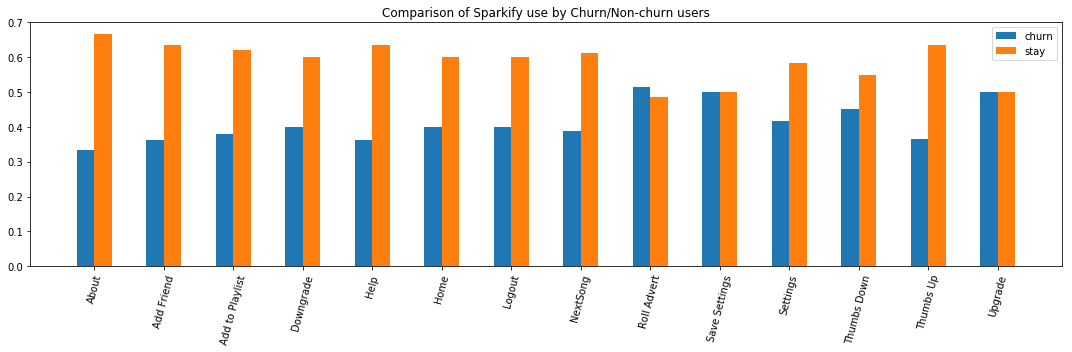

In [27]:
churn = plt.bar(x=[x*2-0.5 for x in range(0,len(non_bin_columns))],height=churns_comp_df[non_bin_columns].loc[0], width=0.5, label='churn')
stay = plt.bar(x=[x*2 for x in range(0,len(non_bin_columns))],height=churns_comp_df[non_bin_columns].loc[1], width=0.5, label='stay')
plt.xticks([x*2-0.25 for x in range(0,len(non_bin_columns))],non_bin_columns,rotation=75);
plt.title('Comparison of Sparkify use by Churn/Non-churn users');
plt.legend(handles=[churn,stay])
plt.tight_layout()
plt.savefig('Comparison.png')
plt.show()

## Observations
Quick observations show that those who didn't churn were generally more 'hands on.' They visited the "NextSong" page over 50% more than those who did churn. They visited settings slightly more, the home page, and added almost twice as many friends. Those who didn't churn also hit the "thumbs up" nearly twice as much, likely allowing Sparkify to better match songs for the user.

Unfortunately, users who churned received slightly more ads even with decreased use. This may be part of the problem.

# More specific *churn* definition
Given that we have timestamps available and can easily determine which users downgraded their service, the ML will be better suited with less sparse data on users who "churn." For example, calculating statistics and still only having 1 row per user indicating 'churn' gives us 225 out of 278154 rows to use as positively labeled rows in ML. It might be more useful to have "dowgrades in 48 hours" be our church definition. This allows for more rows, and it would be a step closer to providing a possible intervention window for Sparkify, allowing them to take steps to avoid losing the user from paid service.

In [28]:
churns = list(df.where(df.page=='Cancellation Confirmation').select('userId').toPandas()['userId'])
churns = set([int(x) for x in churns])
flag_churn = f.udf(lambda x: 1 if int(x) in churns else 0, IntegerType())

In [29]:
df = df.withColumn('churns', flag_churn(df.userId))

In [30]:
df = df.withColumn('CancelTime',f.when(df['page'] == 'Cancellation Confirmation', df['ts']).otherwise(None))

In [31]:
df.persist()
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', datetime='2018-10-01 00:01:57', churns=0, CancelTime=None)

In [32]:
all_time = w.partitionBy('userId')\
                .orderBy('ts')\
                .rangeBetween(w.unboundedPreceding,w.unboundedFollowing)
to_now = w.partitionBy('userId')\
                .orderBy('ts')\
                .rangeBetween(w.unboundedPreceding,0)
to_now_all = w.orderBy('ts')\
                .rangeBetween(w.unboundedPreceding,0)

In [33]:
# define the forward-filled column
filled_column = f.last(df['CancelTime']).over(all_time)

# do the fill
df = df.withColumn('Cancel_Time', filled_column)

In [34]:
df = df.drop('CancelTime')
df = df.withColumn('Until_Cancel',df.Cancel_Time - df.ts)

In [35]:
df = df.withColumn('CancelDate', f.from_unixtime(df.Cancel_Time/1000))
check_48 = f.udf(lambda x: 1 if x != None and x <= 172800000 else 0,IntegerType())
check_week = f.udf(lambda x: 1 if x != None and x <= 604800000 else 0,IntegerType())
check_2_weeks = f.udf(lambda x: 1 if x != None and x <= 1209600000 else 0,IntegerType())
df = df.withColumn('CancelIn48',check_48(df.Until_Cancel))
df = df.withColumn('CancelInWeek',check_week(df.Until_Cancel))
df = df.withColumn('CancelIn2Weeks', check_2_weeks(df.Until_Cancel))

In [36]:
window_48 = w.partitionBy('userId')\
            .orderBy('ts')\
            .rangeBetween(-172800000,0)
window_1_week = w.partitionBy('userId')\
            .orderBy('ts')\
            .rangeBetween(-604800000,0)
window_2_weeks = w.partitionBy('userId')\
            .orderBy('ts')\
            .rangeBetween(-1209600000,0)

In [37]:
df = df.withColumn('actions_48',f.count(df.page).over(window_48))\
    .withColumn('actions_week', f.count(df.page).over(window_1_week))\
    .withColumn('actions_2weeks', f.count(df.page).over(window_2_weeks))

In [38]:
advert = f.udf(lambda x: 1 if x =='Roll Advert' else 0, IntegerType())
df = df.withColumn('ad_here',advert(df.page))

In [39]:
df.persist()
df.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', datetime='2018-10-08 12:58:54', churns=0, Cancel_Time=None, Until_Cancel=None, CancelDate=None, CancelIn48=0, CancelInWeek=0, CancelIn2Weeks=0, actions_48=1, actions_week=1, actions_2weeks=1, ad_here=0)

In [40]:
friend = f.udf(lambda x: 1 if x =='Add Friend' else 0, IntegerType())
df = df.withColumn('friend_here',friend(df.page))
total_friends = f.sum(df['friend_here']).over(to_now)
df = df.withColumn('friends',total_friends)

In [41]:
df = df.withColumn('ads_2_weeks',f.sum(df.ad_here).over(window_2_weeks))\
    .withColumn('ads_1_week',f.sum(df.ad_here).over(window_1_week))\
    .withColumn('ads_48',f.sum(df.ad_here).over(window_48))

# df.select('ads_2_weeks', 'ads_1_week','ads_48','page','userID','ad_here','Until_Cancel').where(df.ad_here==1).show(80)

In [42]:
#average session item per userId over various time windows
df = df.withColumn('sessionItems_48',f.mean(df.itemInSession).over(window_48))\
        .withColumn('sessionItems_week',f.mean(df.itemInSession).over(window_1_week))\
        .withColumn('sessionItems_2_weeks',f.mean(df.itemInSession).over(window_2_weeks))

In [43]:
df = df.withColumn('ads_per_action_48',f.col('ads_48')/f.col('actions_48'))\
        .withColumn('ads_per_action_week',f.col('ads_1_week')/f.col('actions_week'))\
        .withColumn('ads_per_action_2_weeks',f.col('ads_2_weeks')/f.col('actions_2weeks'))

In [44]:
df.persist()
df.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', datetime='2018-10-08 12:58:54', churns=0, Cancel_Time=None, Until_Cancel=None, CancelDate=None, CancelIn48=0, CancelInWeek=0, CancelIn2Weeks=0, actions_48=1, actions_week=1, actions_2weeks=1, ad_here=0, friend_here=0, friends=0, ads_2_weeks=0, ads_1_week=0, ads_48=0, sessionItems_48=0.0, sessionItems_week=0.0, sessionItems_2_weeks=0.0, ads_per_action_48=0.0, ads_per_action_week=0.0, ads_per_action_2_weeks=0.0)

In [45]:
print(datetime.datetime.now())

2019-04-07 00:48:56.397781


In [46]:
print(time_elapsed())

0:03:04.598451


In [47]:
#Test Feature function
##This function allows for a quick examination of new features, comparing churning users
##to non-churning users. Time column can be changed to varying cancellation timeline columns

def test_feat(feat):
    print(df.groupBy('CancelIn48').avg(feat).collect())

In [48]:
#Counts number of unique sessions for a user up to this point
#https://stackoverflow.com/a/45869254/9554411
df = df.withColumn('sessions',f.size(f.collect_set('sessionId').over(to_now)))

In [49]:
df.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', datetime='2018-10-08 12:58:54', churns=0, Cancel_Time=None, Until_Cancel=None, CancelDate=None, CancelIn48=0, CancelInWeek=0, CancelIn2Weeks=0, actions_48=1, actions_week=1, actions_2weeks=1, ad_here=0, friend_here=0, friends=0, ads_2_weeks=0, ads_1_week=0, ads_48=0, sessionItems_48=0.0, sessionItems_week=0.0, sessionItems_2_weeks=0.0, ads_per_action_48=0.0, ads_per_action_week=0.0, ads_per_action_2_weeks=0.0, sessions=1)

In [50]:
df = df.withColumn('sessions_48',f.size(f.collect_set('sessionId').over(window_48)))

In [51]:
df = df.withColumn('sessions_2weeks', f.size(f.collect_set('sessionId').over(window_2_weeks)) )

In [52]:
df = df.withColumn('avgSessionItems', f.mean('itemInSession').over(to_now))

In [53]:
df = df.withColumn('maxItems', f.max('itemInSession').over(to_now))

In [54]:
df.persist()
df.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', datetime='2018-10-08 12:58:54', churns=0, Cancel_Time=None, Until_Cancel=None, CancelDate=None, CancelIn48=0, CancelInWeek=0, CancelIn2Weeks=0, actions_48=1, actions_week=1, actions_2weeks=1, ad_here=0, friend_here=0, friends=0, ads_2_weeks=0, ads_1_week=0, ads_48=0, sessionItems_48=0.0, sessionItems_week=0.0, sessionItems_2_weeks=0.0, ads_per_action_48=0.0, ads_per_action_week=0.0, ads_per_action_2_weeks=0.0, sessions=1, sessions_48=1, sessions_2weeks=1, avgSessionItems

In [55]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- churns: integer (nullable = true)
 |-- Cancel_Time: long (nullable = true)
 |-- Until_Cancel: long (nullable = true)
 |-- CancelDate: string (nullable = true)
 |-- CancelIn48: integer (nullable = true)
 |-- CancelInWeek: integer (nullable = true)
 |-- CancelIn2

In [56]:
check_put = f.udf(lambda x: 1 if x == "PUT" else 0,IntegerType())
df = df.withColumn('putHere',check_put(df.method))
check_get = f.udf(lambda x: 1 if x == "GET" else 0,IntegerType())
df = df.withColumn('getHere',check_get(df.method))

df = df.withColumn('get_48',f.sum(df.getHere).over(window_48))\
        .withColumn('get_week',f.sum(df.getHere).over(window_1_week))\
        .withColumn('get_2_weeks',f.sum(df.getHere).over(window_2_weeks))

df = df.withColumn('put_48',f.sum(df.putHere).over(window_48))\
        .withColumn('put_week',f.sum(df.putHere).over(window_1_week))\
        .withColumn('put_2_weeks',f.sum(df.putHere).over(window_2_weeks))

df = df.withColumn('get_put_48',df.get_48/df.put_48)\
        .withColumn('get_put_week',df.get_week/df.put_week)\
        .withColumn('get_put_2_weeks',df.get_2_weeks/df.put_2_weeks)

In [57]:
df.select('userId','getHere','putHere','method', 'get_48', 'put_48','get_put_48').show(20)

+------+-------+-------+------+------+------+-------------------+
|userId|getHere|putHere|method|get_48|put_48|         get_put_48|
+------+-------+-------+------+------+------+-------------------+
|100010|      0|      1|   PUT|     0|     1|                0.0|
|100010|      0|      1|   PUT|     0|     2|                0.0|
|100010|      0|      1|   PUT|     0|     3|                0.0|
|100010|      0|      1|   PUT|     0|     4|                0.0|
|100010|      0|      1|   PUT|     0|     5|                0.0|
|100010|      0|      1|   PUT|     0|     6|                0.0|
|100010|      0|      1|   PUT|     0|     7|                0.0|
|100010|      0|      1|   PUT|     0|     8|                0.0|
|100010|      1|      0|   GET|     1|     8|              0.125|
|100010|      0|      1|   PUT|     1|     9| 0.1111111111111111|
|100010|      0|      1|   PUT|     1|    10|                0.1|
|100010|      0|      1|   PUT|     1|    11|0.09090909090909091|
|100010|  

In [58]:
df.select('length','CancelIn48').where(df.method=='PUT').where(df.CancelIn48=='0').count()

251645

In [59]:
print(datetime.datetime.now())

2019-04-07 00:50:50.869457


In [60]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- churns: integer (nullable = true)
 |-- Cancel_Time: long (nullable = true)
 |-- Until_Cancel: long (nullable = true)
 |-- CancelDate: string (nullable = true)
 |-- CancelIn48: integer (nullable = true)
 |-- CancelInWeek: integer (nullable = true)
 |-- CancelIn2

In [61]:
features = df.columns
print(features)

['artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName', 'length', 'level', 'location', 'method', 'page', 'registration', 'sessionId', 'song', 'status', 'ts', 'userAgent', 'userId', 'datetime', 'churns', 'Cancel_Time', 'Until_Cancel', 'CancelDate', 'CancelIn48', 'CancelInWeek', 'CancelIn2Weeks', 'actions_48', 'actions_week', 'actions_2weeks', 'ad_here', 'friend_here', 'friends', 'ads_2_weeks', 'ads_1_week', 'ads_48', 'sessionItems_48', 'sessionItems_week', 'sessionItems_2_weeks', 'ads_per_action_48', 'ads_per_action_week', 'ads_per_action_2_weeks', 'sessions', 'sessions_48', 'sessions_2weeks', 'avgSessionItems', 'maxItems', 'putHere', 'getHere', 'get_48', 'get_week', 'get_2_weeks', 'put_48', 'put_week', 'put_2_weeks', 'get_put_48', 'get_put_week', 'get_put_2_weeks']


In [62]:
feats = ['itemInSession','length', 'page','sessionId', 'CancelIn48','CancelIn2Weeks','CancelInWeek', 'actions_48', 'actions_week', 'actions_2weeks', 'friends', 'ads_2_weeks', 'ads_1_week', 'ads_48', 'sessionItems_48', 'sessionItems_week', 'sessionItems_2_weeks', 'ads_per_action_48', 'ads_per_action_week', 'ads_per_action_2_weeks', 'sessions', 'sessions_48', 'sessions_2weeks', 'avgSessionItems', 'maxItems', 'get_48', 'get_week', 'get_2_weeks', 'put_48', 'put_week', 'put_2_weeks', 'get_put_48', 'get_put_week', 'get_put_2_weeks']

In [63]:
print(datetime.datetime.now())

2019-04-07 00:50:50.941622


In [64]:
#Select features that do not have a 1:1 ratio 
features = []
for col in feats:
    try:
        a = df.groupBy('CancelIn2Weeks').avg(col).collect()[0][1]
        b = df.groupBy('CancelIn2Weeks').avg(col).collect()[1][1]
        rel = abs(1-(a/b))
        if rel > 1.05 or rel < .95:
            features.append(col)
    except:
        pass
print(features)

['itemInSession', 'length', 'sessionId', 'actions_48', 'actions_week', 'actions_2weeks', 'friends', 'ads_2_weeks', 'ads_1_week', 'ads_48', 'sessionItems_48', 'sessionItems_week', 'sessionItems_2_weeks', 'ads_per_action_48', 'ads_per_action_week', 'ads_per_action_2_weeks', 'sessions', 'sessions_48', 'sessions_2weeks', 'avgSessionItems', 'maxItems', 'get_48', 'get_week', 'get_2_weeks', 'put_48', 'put_week', 'put_2_weeks', 'get_put_48', 'get_put_week', 'get_put_2_weeks']


In [65]:
print(datetime.datetime.now())

2019-04-07 01:03:18.581765


In [66]:
#Remove non-quantitative features that can't be used in ML model
non_quant = ['churns','Until_Cancel','sessionId','friend_here','ad_here', 'CancelIn48', 'CancelInWeek']
for feat in non_quant:
    try:
        features.remove(feat)
    except:
        pass
print(features)

['itemInSession', 'length', 'actions_48', 'actions_week', 'actions_2weeks', 'friends', 'ads_2_weeks', 'ads_1_week', 'ads_48', 'sessionItems_48', 'sessionItems_week', 'sessionItems_2_weeks', 'ads_per_action_48', 'ads_per_action_week', 'ads_per_action_2_weeks', 'sessions', 'sessions_48', 'sessions_2weeks', 'avgSessionItems', 'maxItems', 'get_48', 'get_week', 'get_2_weeks', 'put_48', 'put_week', 'put_2_weeks', 'get_put_48', 'get_put_week', 'get_put_2_weeks']


In [67]:
df = df.fillna(-1)
df.persist()
df.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', datetime='2018-10-08 12:58:54', churns=0, Cancel_Time=-1, Until_Cancel=-1, CancelDate=None, CancelIn48=0, CancelInWeek=0, CancelIn2Weeks=0, actions_48=1, actions_week=1, actions_2weeks=1, ad_here=0, friend_here=0, friends=0, ads_2_weeks=0, ads_1_week=0, ads_48=0, sessionItems_48=0.0, sessionItems_week=0.0, sessionItems_2_weeks=0.0, ads_per_action_48=0.0, ads_per_action_week=0.0, ads_per_action_2_weeks=0.0, sessions=1, sessions_48=1, sessions_2weeks=1, avgSessionItems=0.0

In [68]:
#if new features created, drop old vectorized column to create new
# df = df.drop('DescVec')

In [69]:
feat_cols = features
feat_list = 'churn in 2 week'

In [70]:
print(feat_cols)

['itemInSession', 'length', 'actions_48', 'actions_week', 'actions_2weeks', 'friends', 'ads_2_weeks', 'ads_1_week', 'ads_48', 'sessionItems_48', 'sessionItems_week', 'sessionItems_2_weeks', 'ads_per_action_48', 'ads_per_action_week', 'ads_per_action_2_weeks', 'sessions', 'sessions_48', 'sessions_2weeks', 'avgSessionItems', 'maxItems', 'get_48', 'get_week', 'get_2_weeks', 'put_48', 'put_week', 'put_2_weeks', 'get_put_48', 'get_put_week', 'get_put_2_weeks']


In [71]:
print(datetime.datetime.now())
assembler = VectorAssembler(inputCols=feat_cols, outputCol='DescVec')
df = assembler.transform(df)

2019-04-07 01:03:38.024527


In [72]:
df.persist()
df.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', datetime='2018-10-08 12:58:54', churns=0, Cancel_Time=-1, Until_Cancel=-1, CancelDate=None, CancelIn48=0, CancelInWeek=0, CancelIn2Weeks=0, actions_48=1, actions_week=1, actions_2weeks=1, ad_here=0, friend_here=0, friends=0, ads_2_weeks=0, ads_1_week=0, ads_48=0, sessionItems_48=0.0, sessionItems_week=0.0, sessionItems_2_weeks=0.0, ads_per_action_48=0.0, ads_per_action_week=0.0, ads_per_action_2_weeks=0.0, sessions=1, sessions_48=1, sessions_2weeks=1, avgSessionItems=0.0

In [73]:
data = df.select(f.col("CancelIn2Weeks").alias("label"), f.col('DescVec').alias("features"))

In [74]:
data.persist()
data.head()

Row(label=0, features=SparseVector(29, {1: 202.971, 2: 1.0, 3: 1.0, 4: 1.0, 15: 1.0, 16: 1.0, 17: 1.0, 23: 1.0, 24: 1.0, 25: 1.0}))

In [75]:
train_data, test_data = data.randomSplit([0.75,0.25], seed=42)

In [76]:
print(time_elapsed())

0:17:48.288787


In [77]:
depth = 10
stepSize = 0.3
gbt = GBTClassifier(maxDepth = depth, stepSize = stepSize)
# svc = LinearSVC()
# lr = LogisticRegression()
# rf = RandomForestClassifier(maxDepth=25, seed=42)

In [78]:
# Param Grid testing in this cell
# grid = ParamGridBuilder()\
#     .addGrid(gbt.maxDepth,[10])\
#     .addGrid(gbt.stepSize,[0.3,0.4])\
#     .build()
# evaluator = MulticlassClassificationEvaluator(metricName='weightedRecall')

In [79]:
prev = datetime.datetime.now()
print(prev)

2019-04-07 01:03:40.227068


In [80]:
model_start = datetime.datetime.now()

In [81]:
# tv = TrainValidationSplit(estimator=gbt, estimatorParamMaps=grid, evaluator=evaluator, parallelism=2, seed=42)
# tv_model = tv.fit(train_data)
# results = tv_model.transform(test_data)

In [82]:
gbt_model = gbt.fit(train_data)
results = gbt_model.transform(test_data)

In [83]:
# svc_model = svc.fit(train_data)
# results = svc_model.transform(test_data)

In [84]:
# lr_model = lr.fit(train_data)
# results = lr_model.transform(test_data)

In [85]:
# rf_model = rf.fit(train_data)
# results = rf_model.transform(test_data)

In [86]:
post = datetime.datetime.now()
print(post)

2019-04-07 01:45:02.422642


In [87]:
results.persist()
results.head()

Row(label=0, features=SparseVector(29, {0: 1.0, 1: 254.7979, 2: 2.0, 3: 2.0, 4: 2.0, 5: 3.0, 9: 0.5, 10: 0.5, 11: 0.5, 15: 5.0, 16: 1.0, 17: 1.0, 18: 25.3675, 19: 59.0, 23: 2.0, 24: 2.0, 25: 2.0}), rawPrediction=DenseVector([1.6083, -1.6083]), probability=DenseVector([0.9615, 0.0385]), prediction=0.0)

In [89]:
num_found = results.filter((results.label == 1) & (results.prediction==1)).count()
print(num_found)
num_actual = results.filter(results.label == 1).count()
print(num_actual)
false_pos = results.filter((results.label==0) & (results.prediction==1)).count()
print(false_pos)
percentage_found = num_found/num_actual * 100
print(percentage_found)
print(datetime.datetime.now())

6381
6685
14
95.45250560957366
2019-04-07 01:48:29.638170


In [90]:
num_found/num_actual

0.9545250560957367

In [91]:
# best = tv_model.bestModel

In [92]:
# cv_model.avgMetrics

In [93]:
# best.extractParamMap()

In [94]:
print(post-prev)
print(num_found)

0:41:22.195574
6381


In [95]:
print(results.filter(results.label==results.prediction).count())
print(results.count())

68972
69290


In [96]:
print(datetime.datetime.now())
results.unpersist()

2019-04-07 01:50:37.677107


DataFrame[label: int, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [97]:
print(time_elapsed())

1:04:54.515954


In [98]:
model_time = time_elapsed(start=model_start)
print(model_time)

0:47:06.395893


In [99]:
print(f'Depth = {depth}', f'stepSize={stepSize}',\
      f'found={num_found}', f'time_elapsed = {model_time}',\
      f'list = {feat_list},', f'Percentage = {percentage_found}')

Depth = 10 stepSize=0.3 found=6381 time_elapsed = 0:47:06.395893 list = churn in 2 week, Percentage = 95.45250560957366


Depth = 3 stepSize=0.3 found=15 time_elapsed = ???? list = long

Depth = 10 stepSize=0.3 found=1392 time_elapsed = 0:37:32.540361 list = long

Depth = 10 stepSize=0.3 found=582 time_elapsed = 0:31:27.208707 list = short

Depth = 10 stepSize=0.3 found=1561 time_elapsed = 0:40:00.490014 list = modified, Percentage = 91.87757504414361

Depth = 10 stepSize=0.3 found=1596 time_elapsed = 0:36:25.867960 list = modified + friends, Percentage = 93.93761035903474

Depth = 10 stepSize=0.3 found=1591 time_elapsed = 0:38:09.307843 list = modified + friends - some things, Percentage = 93.64331959976457

Depth = 10 stepSize=0.3 found=1598 time_elapsed = 0:37:50.957526 list = .05, Percentage = 94.05532666274279

Depth = 10 stepSize=0.3 found=1510 time_elapsed = 0:39:22.755387 list = .1 differentiator, Percentage = 88.875809299588

Depth = 10 stepSize=0.3 found=1614 time_elapsed = 0:39:35.482227 list = w/ get-put, Percentage = 94.9970570924073

Depth = 10 stepSize=0.3 found=3921 time_elapsed = 0:42:15.085041 list = churn in week, Percentage = 94.5274831243973

Depth = 10 stepSize=0.3 found=6363 time_elapsed = 0:43:08.062518 list = churn in 2 week, Percentage = 95.18324607329843

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.